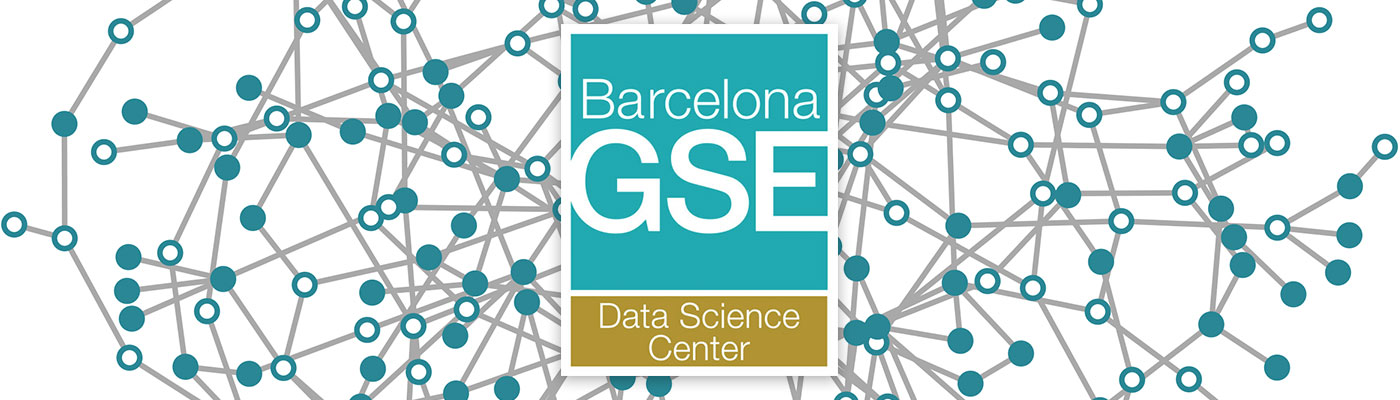

In [1]:
from IPython import display
display.Image("bse.jpeg")

# Customer Churn Analysis and Classification

##  Lluïsa Rull Farran, Tobi Pfeiffer, Pearl Herrero

In [2]:
# Importing our libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import functools

# Sklearn all
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from IPython import display


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)

# Load data
data = pd.read_csv('churn_data.csv', sep=';')
data

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.10,110,89.00,9.87,10.00
1,0,107,1,1,3.70,1,161.60,123,82.00,9.78,13.70
2,0,137,1,0,0.00,0,243.40,114,52.00,6.06,12.20
3,0,84,0,0,0.00,2,299.40,71,57.00,3.10,6.60
4,0,75,0,0,0.00,3,166.70,113,41.00,7.42,10.10
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.20,77,71.70,10.78,9.90
3329,0,68,1,0,0.34,3,231.10,57,56.40,7.67,9.60
3330,0,28,1,0,0.00,2,180.80,109,56.00,14.44,14.10
3331,0,184,0,0,0.00,2,213.80,105,50.00,7.98,5.00


# Data Exploration

In [3]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


We can see there is no null data neither categorical data in the dataset

In [4]:
# Investigate outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5*IQR),(Q3 + 1.5*IQR))

Churn              0.00
AccountWeeks      -5.50
ContractRenewal    1.00
DataPlan          -1.50
DataUsage         -2.67
CustServCalls     -0.50
DayMins           34.65
DayCalls          46.50
MonthlyCharge     13.20
OverageFee         3.17
RoamMins           3.10
dtype: float64 Churn               0.00
AccountWeeks      206.50
ContractRenewal     1.00
DataPlan            2.50
DataUsage           4.45
CustServCalls       3.50
DayMins           325.45
DayCalls          154.50
MonthlyCharge      98.00
OverageFee         16.93
RoamMins           17.50
dtype: float64


## Choosing the Evaluation Metric 

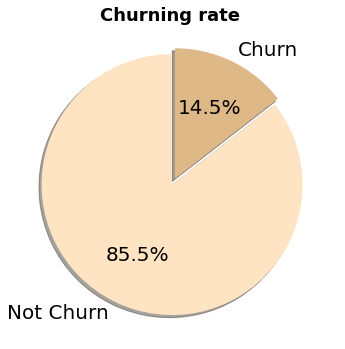

In [5]:
# Ploting and exploring the target 
labels = ['Not Churn', 'Churn']
sizes = data['Churn'].value_counts(sort = True)

colors = ["bisque","burlywood"]
explode = (0.05,0) 
 
plt.figure(figsize=(6,6))
plt.suptitle("Churning rate",y=0.9, size=18, weight='bold')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, 
        startangle=90, textprops={"fontsize":20})
plt.show()

In order to see which is the best evaluation metric to assess the quality of the model, we need to explore the target and see how the data is distributed. As we can see, most of the data (85.5%) is negative and we care about the positve class (which are the attributes that increase the customers' probability to churn). Therefore, since the class we want to predict correctly is missrepresented and there is a downside on predicting False Negatives, F1 score would be better than accuracy. In this specific case, since we are in an unbalanced situation, using accuracy wouldn't be appropriate because by simply classifiying all observations as the majority class (Churing) we would get a high score.

## Understanding the Features 

### Correlation Matrix 

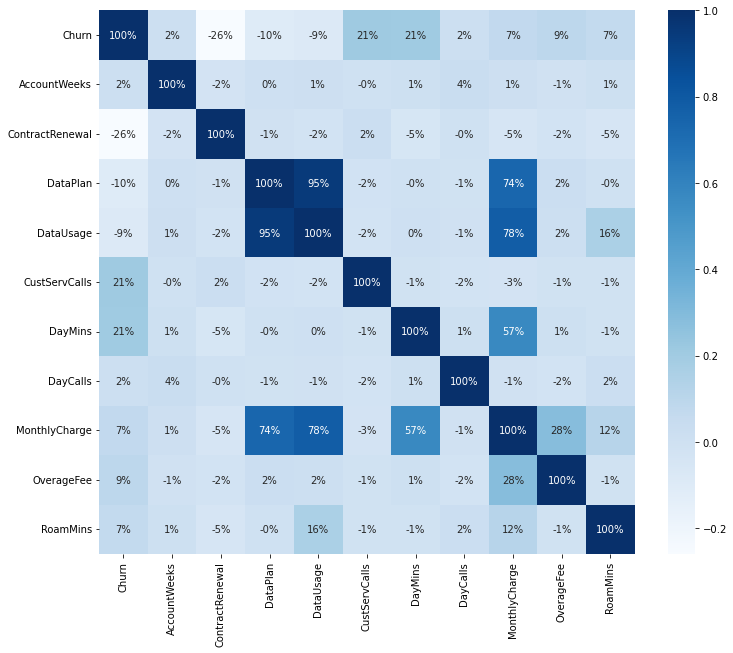

In [6]:
# Correlation map
ax = plt.figure(figsize=(12,10))
sns.heatmap(data.corr(),annot=True,cmap="Blues", fmt='.0%')
plt.show()

n the previous correlation map we are able to see that the probability of churning is negatively correlated with DataUsage and positively correlated with all the other attributes (we are not considering Contract Renewal and Data Plan as they are dummy variables). We have analyzed their impact on churning hereafter.

We are also able to check that DataPlan and DataUsage are highly correlated attributes, and they are also correlated with MonthlyCharge.

## Contract Renewal, Data Plan, Calls to Customer Service 

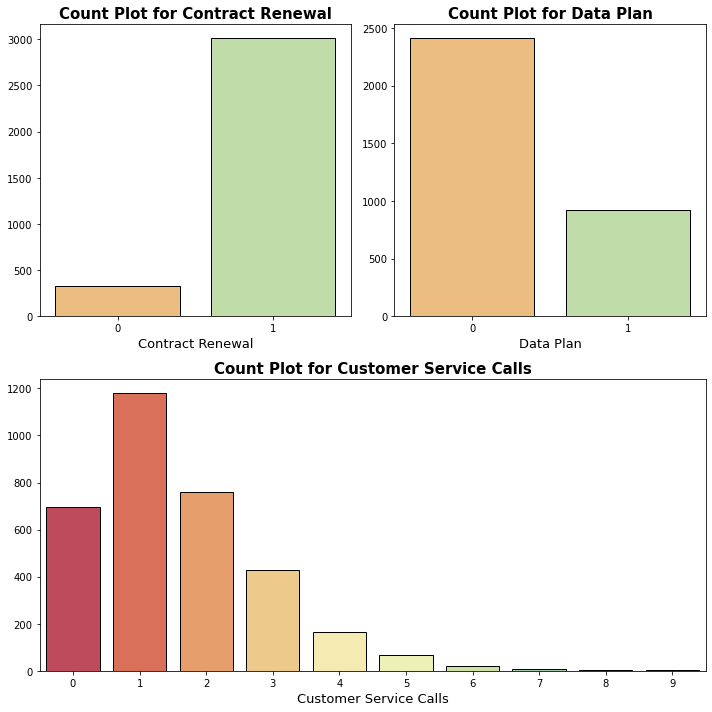

In [7]:
# Ploting other attributes
ax = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.countplot(data = data , x = "ContractRenewal" , palette="Spectral", edgecolor='k')
plt.title("Count Plot for Contract Renewal" , size=15, fontweight='bold', fontfamily='sans')
plt.xlabel("Contract Renewal", size=13, fontweight='light', fontfamily='sans')
plt.ylabel('')
plt.subplot(2,2,2)
sns.countplot(data = data , x = "DataPlan" , palette="Spectral", edgecolor='k')
plt.title("Count Plot for Data Plan" , size=15, fontweight='bold', fontfamily='sans')
plt.xlabel("Data Plan", size=13, fontweight='light', fontfamily='sans')
plt.ylabel('')
plt.subplot(2,2,(3,4))
sns.countplot(data = data , x = "CustServCalls" , palette="Spectral", edgecolor='k')
plt.title("Count Plot for Customer Service Calls" , size=15, fontweight='bold', fontfamily='sans')
plt.xlabel("Customer Service Calls", size=13, fontweight='light', fontfamily='sans')
plt.ylabel('')
plt.tight_layout()
plt.show()

### Contract Renewal and Data Plan 

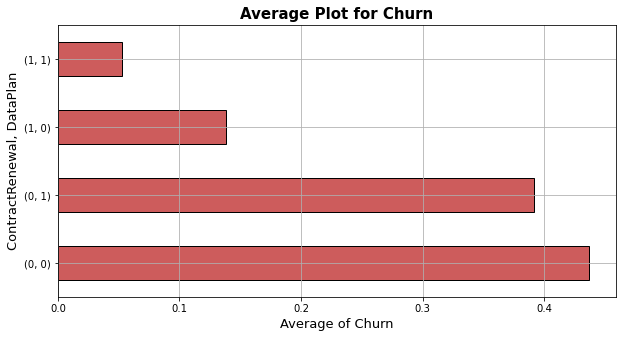

In [8]:
# Contract Renewal and Data Plan impact on Churning Probability
ax = plt.figure(figsize=(10,5))
data.groupby(['ContractRenewal',"DataPlan"])['Churn'].mean().plot(figsize=(10,5),kind="barh",color="indianred",
                                                               edgecolor='k')
plt.title("Average Plot for Churn" , size=15, fontweight='bold', fontfamily='sans')
plt.ylabel("ContractRenewal, DataPlan",size=13, fontweight='light', fontfamily='sans')
plt.xlabel("Average of Churn",size=13, fontweight='light', fontfamily='sans')
plt.grid(True)
plt.show()

Contract Renewal and Data Plan are two important attributes when trying to predict customer churn. If a customer has recently renewed a contract and has a data plan, the probability of churning is much more lower than if he/she has not. Moreover, we can also see that having renewed a contract recently has a higher impact on the churning rate than having a data plan.

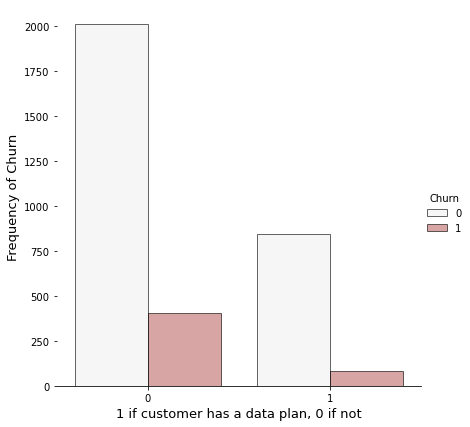

In [9]:
# Compare the distribution of users that churn vs those that do not by number of calls to customer service

count_data = pd.DataFrame(data.groupby(['DataPlan', 'Churn']).size())
count_data.columns = ['Frequency']
count_data['Percent'] = count_data / count_data.groupby(level=0).sum()
count_data = count_data.reset_index()

g = sns.catplot(
    data = count_data, kind="bar", 
    x = 'DataPlan', y = 'Frequency', hue = 'Churn',
    alpha=.6, height=6, color="indianred", edgecolor='k'
)

g.despine(left=True)
g.set_axis_labels("1 if customer has a data plan, 0 if not", "Frequency of Churn",size=13, fontweight='light', fontfamily='sans')
g.legend.set_title("Churn")

### Number of Calls to Customer Service 

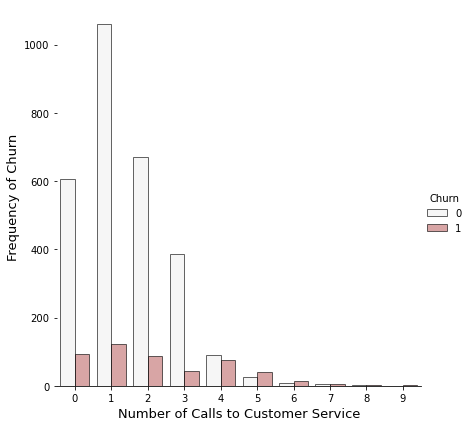

In [10]:
# Compare the distribution of users that churn vs those that do not by number of calls to customer service

count_data = pd.DataFrame(data.groupby(['CustServCalls', 'Churn']).size())
count_data.columns = ['Frequency']
count_data['Percent'] = count_data / count_data.groupby(level=0).sum()
count_data = count_data.reset_index()

g = sns.catplot(
    data = count_data, kind="bar", 
    x = 'CustServCalls', y = 'Frequency', hue = 'Churn',
    alpha=.6, height=6, color="indianred", edgecolor='k'
)

g.despine(left=True)
g.set_axis_labels("Number of Calls to Customer Service", "Frequency of Churn",size=13, fontweight='light', fontfamily='sans')
g.legend.set_title("Churn")

[Text(0.5, 0, 'Number of Calls to Customer Service'),
 Text(0, 0.5, 'Percentage of Churns'),
 Text(0.5, 1.0, 'Evolution of Churns')]

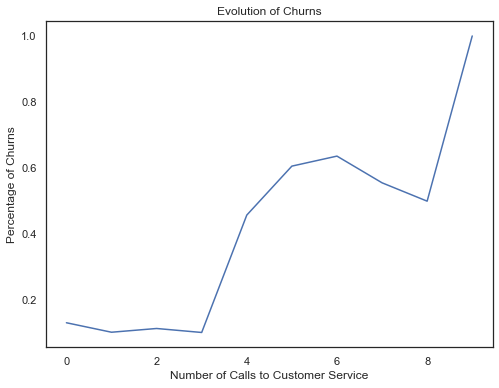

In [11]:
sns.set(rc = {'figure.figsize':(8,6)})
sns.set_theme(style = 'white')

ax = sns.lineplot(x = count_data['CustServCalls'], 
                  y = count_data.loc[count_data['Churn'] == 1]['Percent'], 
                  data = count_data) 

ax.set(xlabel ='Number of Calls to Customer Service', 
       ylabel ='Percentage of Churns',
       title = 'Evolution of Churns')

At about 4 calls, the percentage of customers that churn significantly increases (as a proportion of total customers, grouped by the number of calls to customer service)

Subscribers who do not have a data plan demonstrate a higher probability of churning compared to those that do have a data plan.

### Average Daytime Minutes Per Month 

[Text(0.5, 0, 'Churn'), Text(0, 0.5, 'Average Daytime Minutes Per Month')]

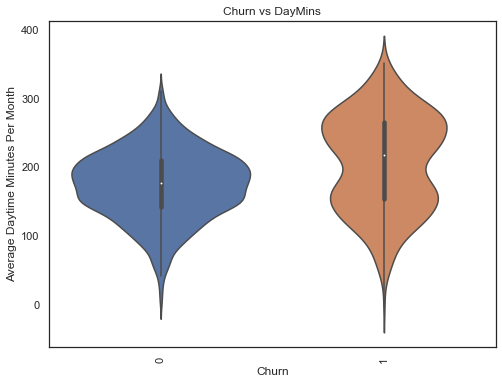

In [12]:
sns.set(rc = {'figure.figsize':(8,6)})
sns.set_theme(style = 'white')

ax = sns.violinplot(x = "Churn", 
                    y = "DayMins",
                    data = data)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax.set_title("Churn vs DayMins")

ax.set(xlabel ='Churn', 
       ylabel ='Average Daytime Minutes Per Month')

Subscribers who do churn demonstrate a different distribution vs those that do not. Their consumption of daytime minutes are more spread out, while non-churners' consupmtions are mostly concentrated in one area.

### Visualise the data

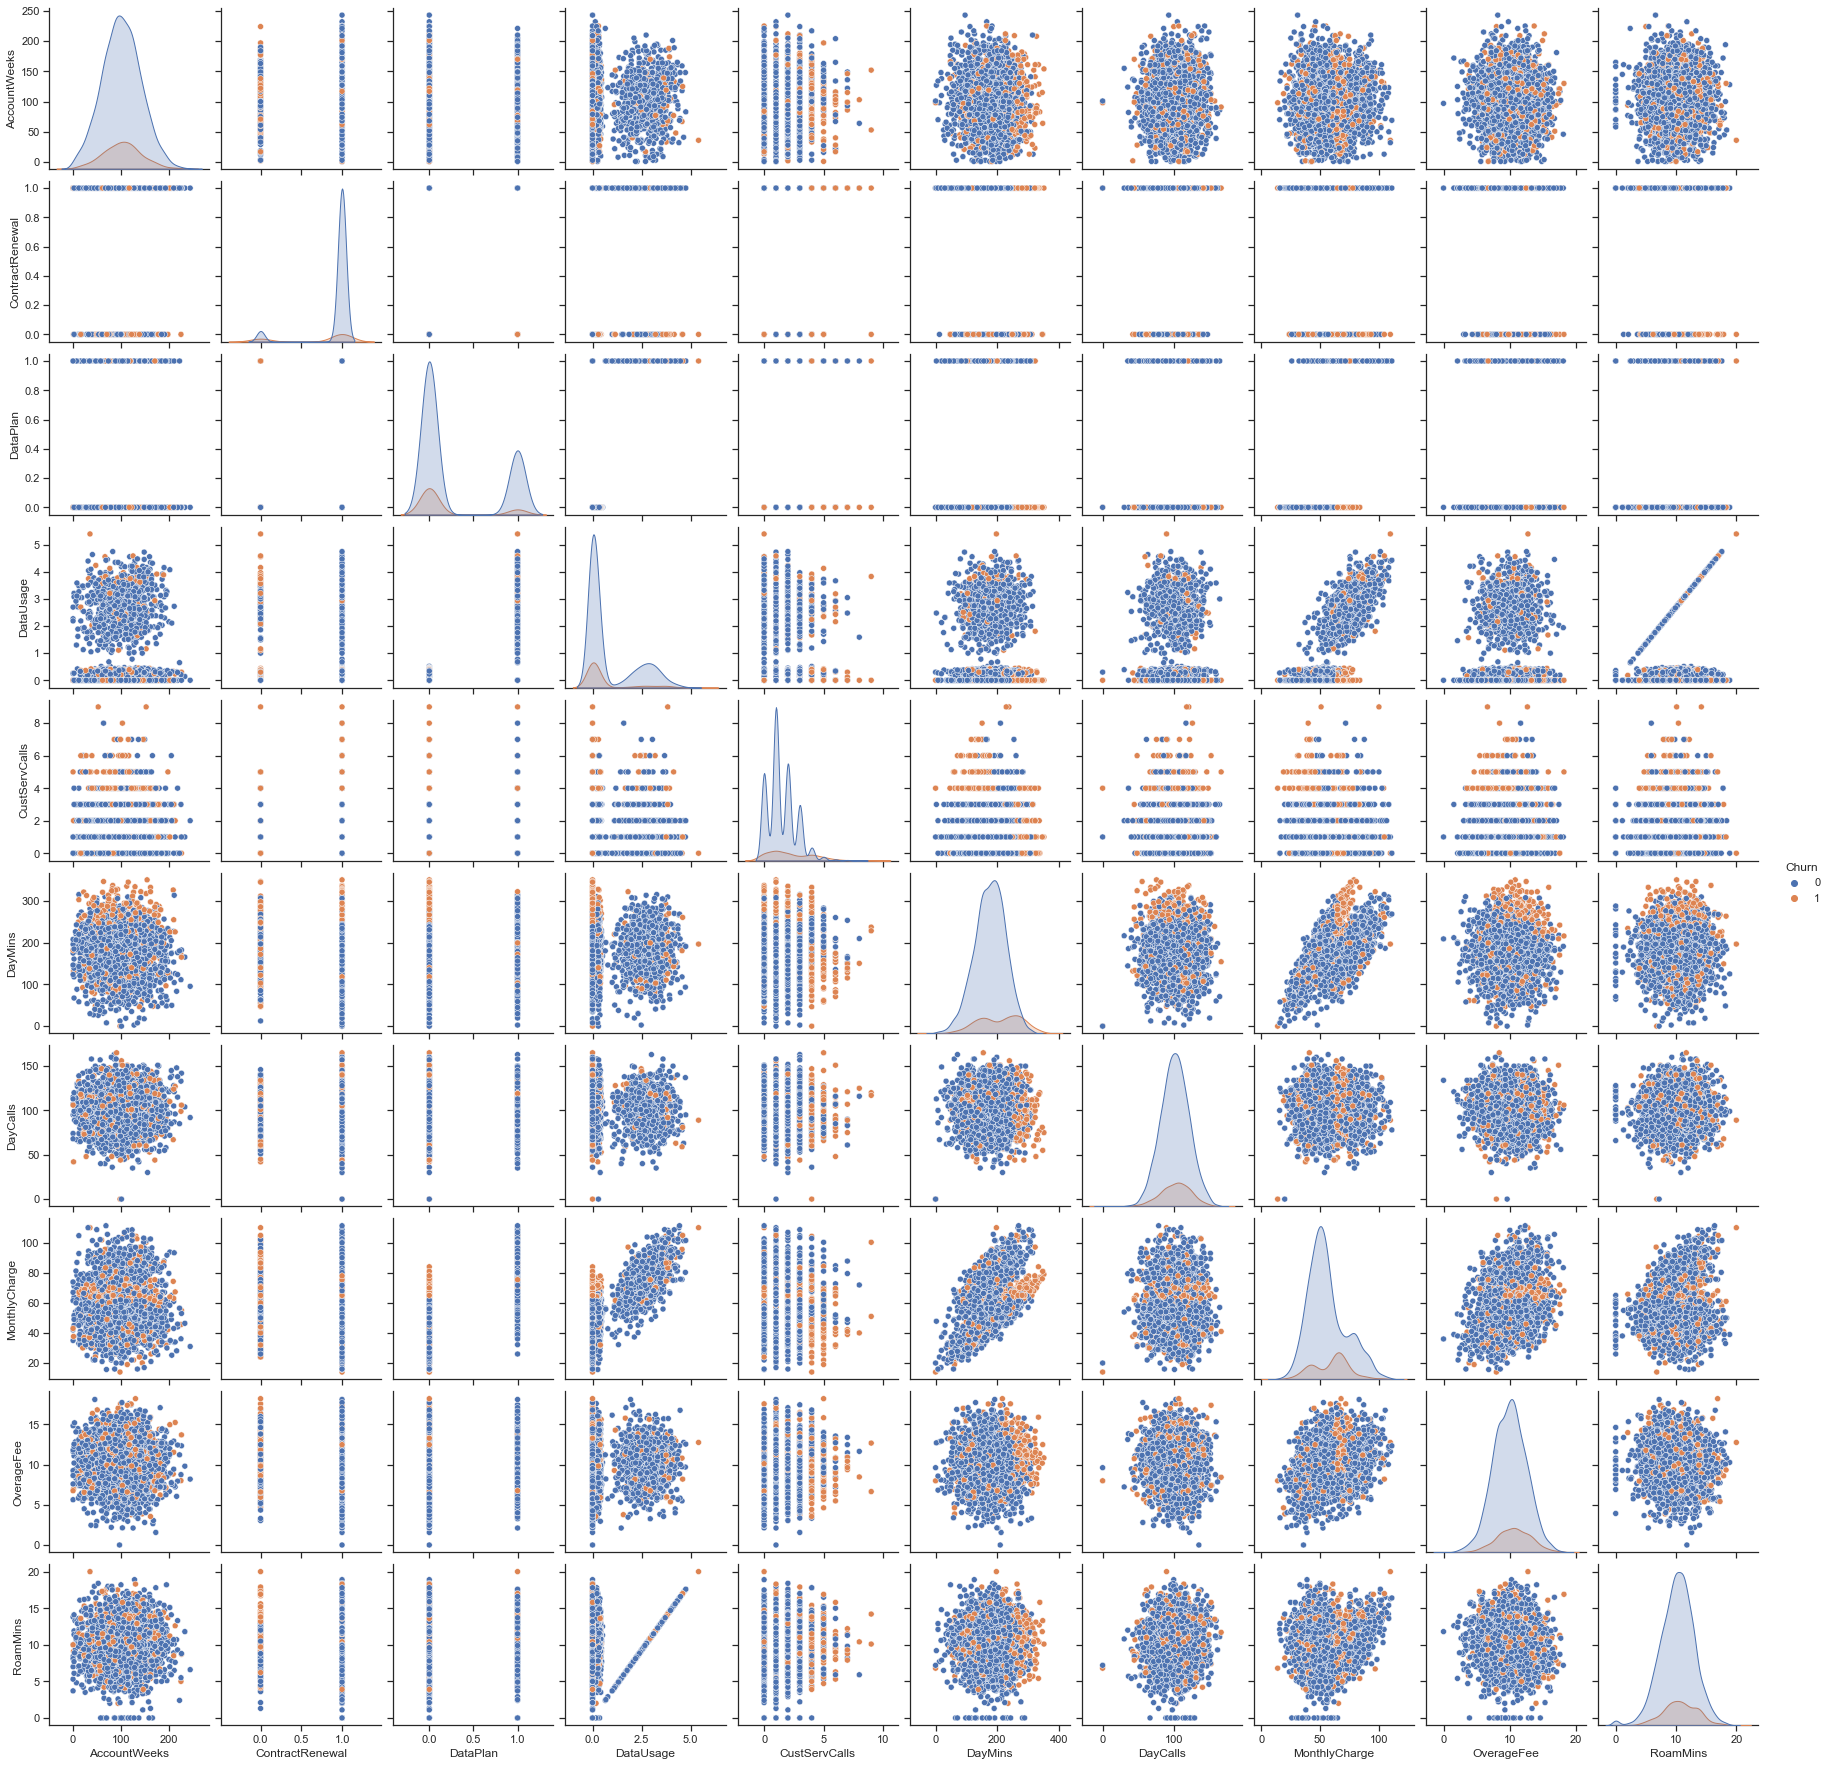

In [13]:
sns.set(style = "ticks")
sns.pairplot(data, hue="Churn")

Based on the graphical representation, it seems like a large share of people who churn have high DayMins and a high Overage fee. Thus we multiply the two, while creating a new column call called DayMinsXOverageFee. Note that these people are also more distributed on the right side of DayMins. Fortunately, DayMins has a bigger support which favours the variable. Following the same logic, we create for more variables multiplying those features that, together, seem to have a postive impact on the churning rate.

# Feature Engineering
## DayMins x Overage Fees

<AxesSubplot:xlabel='DayMins', ylabel='OverageFee'>

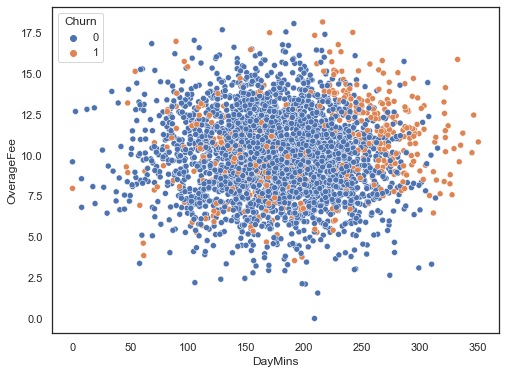

In [14]:
data['DayMinsXOverageFee'] = data['DayMins'] * data['OverageFee']

sns.set_theme(style = 'white')
sns.scatterplot(data = data, 
                y = data['OverageFee'], 
                x = data['DayMins'] , 
                hue = 'Churn')

We observe a high concentration of churn in the northeast of the graph. We can postulate that high OverageFees may be a result of high DayMins

## Base Fee Percent

We assume that Monthly Charge and Overage Fee are comparable and that

<b>Base Fee + Overage Fee = Monthly Charge</b>

We are aware that this is not necessarily an accurate assumption as Monthly Charge is an average over 12 months while Overage Fee is a point-in-time measure.

<AxesSubplot:xlabel='DayMins', ylabel='BaseFeePct'>

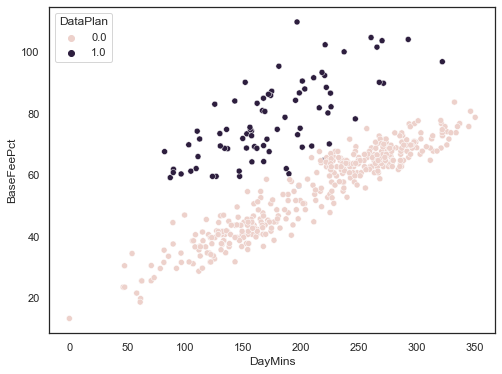

In [15]:
data['BaseFeePct'] = data['MonthlyCharge'] - data['OverageFee'] / data['MonthlyCharge']

sns.set_theme(style = 'white')
sns.scatterplot(data = data.loc[data['Churn'] == 1], 
                y = data['BaseFeePct'], 
                x = data['DayMins'] , 
                hue = 'DataPlan')

Those with a data plan pay a lower "Base Fee" as a percentage of their total.

## Other Features
### Customer Experience, Service Exposure, Day Mins x Account Weeks, Day Mins x Day Calls

In [16]:
data['CusExp'] = data['CustServCalls'] * data['AccountWeeks']
data['ServiceExposure'] = data['AccountWeeks'] * data['DayMins']
data['DayMinsXAccountWeeks'] = data['DayMins'] * data['AccountWeeks']
data['DayMinsXDayCalls'] = data['DayMins'] * data['DayCalls']

data

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,DayMinsXOverageFee,BaseFeePct,CusExp,ServiceExposure,DayMinsXAccountWeeks,DayMinsXDayCalls
0,0,128,1,1,2.70,1,265.10,110,89.00,9.87,10.00,2616.54,88.89,128,33932.80,33932.80,29161.00
1,0,107,1,1,3.70,1,161.60,123,82.00,9.78,13.70,1580.45,81.88,107,17291.20,17291.20,19876.80
2,0,137,1,0,0.00,0,243.40,114,52.00,6.06,12.20,1475.00,51.88,0,33345.80,33345.80,27747.60
3,0,84,0,0,0.00,2,299.40,71,57.00,3.10,6.60,928.14,56.95,168,25149.60,25149.60,21257.40
4,0,75,0,0,0.00,3,166.70,113,41.00,7.42,10.10,1236.91,40.82,225,12502.50,12502.50,18837.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.20,77,71.70,10.78,9.90,1683.84,71.55,384,29990.40,29990.40,12027.40
3329,0,68,1,0,0.34,3,231.10,57,56.40,7.67,9.60,1772.54,56.26,204,15714.80,15714.80,13172.70
3330,0,28,1,0,0.00,2,180.80,109,56.00,14.44,14.10,2610.75,55.74,56,5062.40,5062.40,19707.20
3331,0,184,0,0,0.00,2,213.80,105,50.00,7.98,5.00,1706.12,49.84,368,39339.20,39339.20,22449.00


# Predictive Models

In [17]:
# Bring the data in an appropriate form
X = data.drop('Churn', axis = 1)
y = data['Churn']

# Split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [18]:
# Checking if the test train samples are balanced
print(y_train.mean(), y_test.mean())

0.14599193909538738 0.14272727272727273


## 1. CLASSIFICATION TREE
### Base Model

In [19]:
clf = DecisionTreeClassifier()
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [20]:
# Define function to fit model and predict values

def fit_n_predict(X_train, X_test, y_train, model):
    
    fitted_model = model
    fitted_model = fitted_model.fit(X_train, y_train)
    predictions = fitted_model.predict(X_test)
    
    print("Accuracy Score: {:.2f}".format(accuracy_score(y_test, predictions)))
    print("Precision Score: {:.2f}".format(precision_score(y_test, predictions)))
    print("Recall Score: {:.2f}".format(recall_score(y_test, predictions)))
    print("F1 Score: {:.2f}".format(f1_score(y_test, predictions)))
    
    return fitted_model, predictions

clf, predictions_clf = fit_n_predict(X_train, X_test, y_train, clf)

Accuracy Score: 0.89
Precision Score: 0.61
Recall Score: 0.64
F1 Score: 0.63


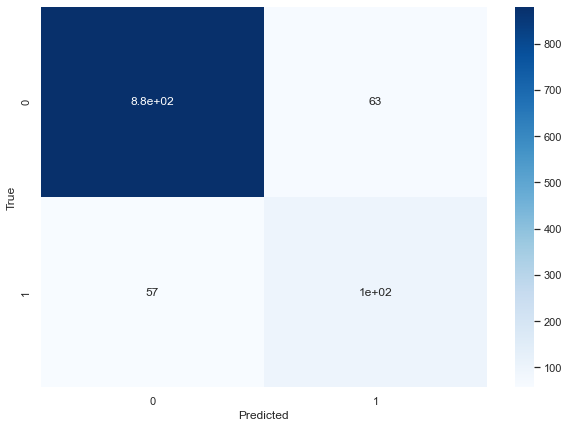

In [21]:
# Define function for plotting a confusion matrix

def conf_mat(y_test, model_predict):

    cm = confusion_matrix(y_test, model_predict, labels=[0,1])
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, cmap="Blues", annot = True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
conf_mat(y_test, predictions_clf)

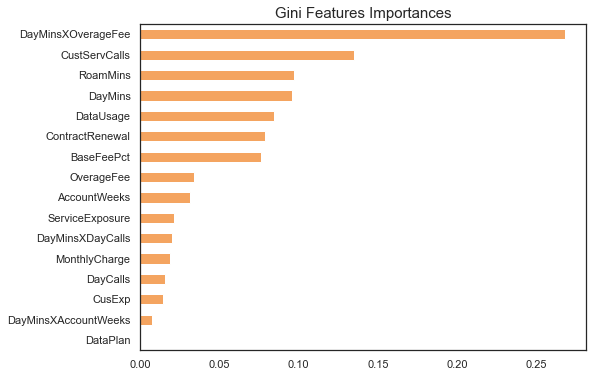

In [22]:
# Define a function for plotting feature importances 

def plot_feats(fitted_model):
    fitted_model.feature_importances_

    features = X.columns

    importances_clf = pd.Series(data = fitted_model.feature_importances_,
                                index= features)

    # Sort importances
    importances_sorted_clf = importances_clf.sort_values()

    # Draw a horizontal barplot of importances_sorted
    importances_sorted_clf.plot(kind='barh', color='sandybrown')
    plt.title('Gini Features Importances', size=15)
    plt.show()
    
plot_feats(clf)

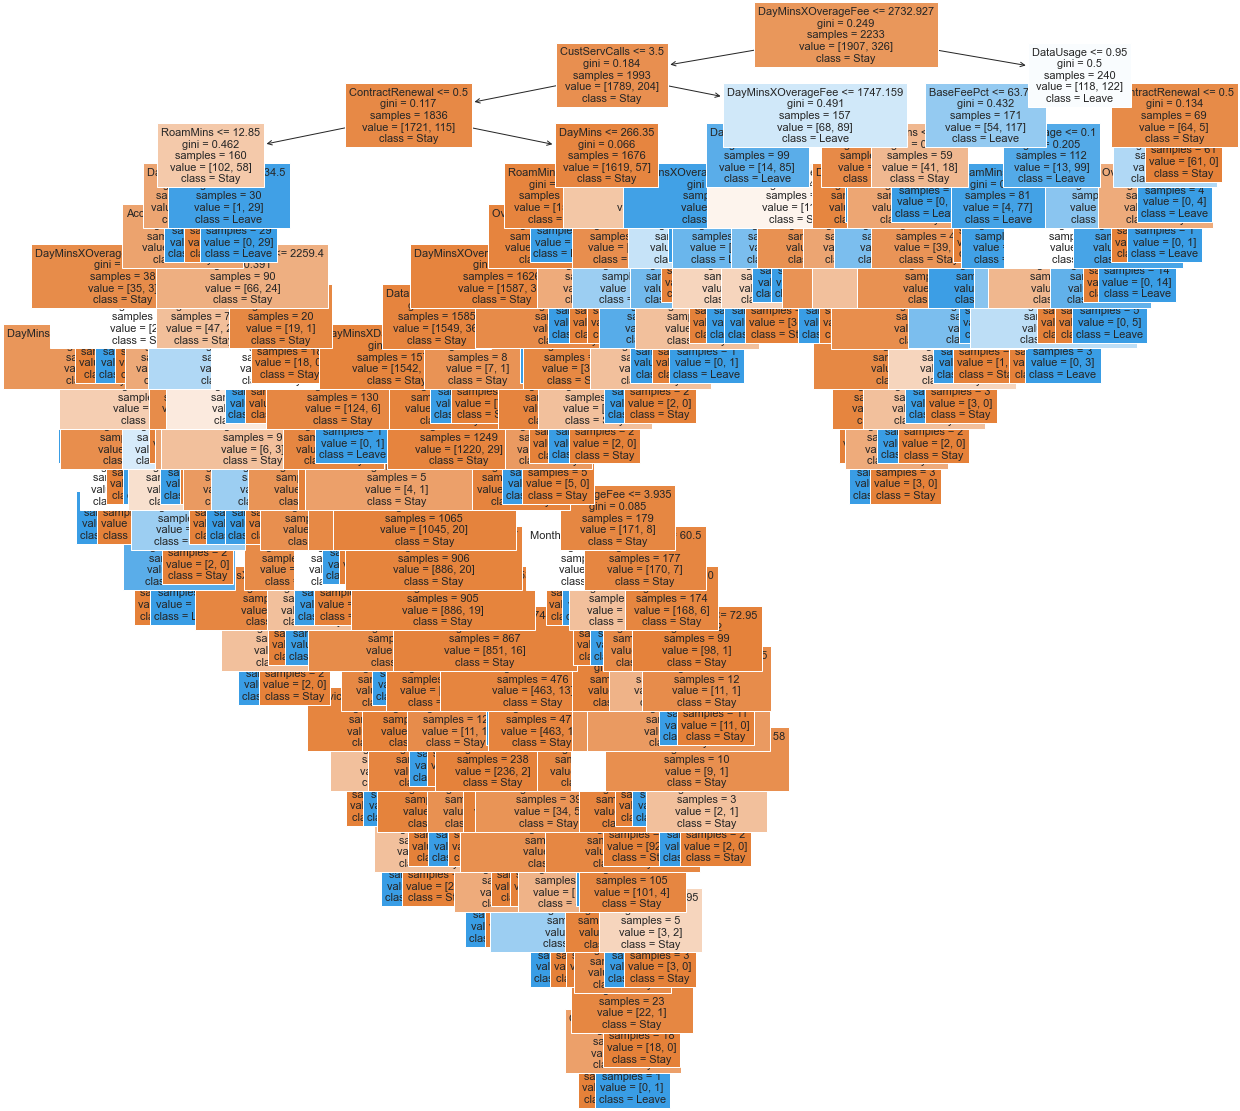

In [23]:
# Plot tree
from sklearn import tree
fig1 = plt.figure(figsize=(20,20))
fig1 = tree.plot_tree(clf,
                   feature_names = X.columns,
                   class_names = {0: 'Stay', 1: 'Leave'},
                   filled = True,
                   fontsize = 11
                  )

### Classification Tree: Hyperparameter Tuning 

In [24]:
# Define a global function to tune the hyperparameters of the model

def tuning(model, parameters, X_train, y_train):
    
    random_estimator = RandomizedSearchCV(estimator = model,
                                          param_distributions = parameters,
                                          n_iter=10, 
                                          scoring='f1', 
                                          n_jobs=-1, 
                                          cv=5, 
                                          verbose=3, 
                                          random_state=420)
    
    random_estimator.fit(X_train, y_train)

    print ('Best Estimator: ', random_estimator.best_estimator_, ' \n')
    
    chosen_model = random_estimator.best_estimator_
    
    return chosen_model

In [25]:
# Finding the best hyperparameters for the classification tree
parameters_tree = {
 "max_depth"        : [4, 5, 6, 7, 8, 9, 10, 11, 12],  
 "criterion"        : ['gini', 'entropy'],
 "max_features"     : [4, 5, 6, 7, 8, 9, 10, 11, 12],
}

clf2 = tuning(DecisionTreeClassifier(), parameters_tree, X_train, y_train)

clf2

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Estimator:  DecisionTreeClassifier(max_depth=6, max_features=8)  



DecisionTreeClassifier(max_depth=6, max_features=8)

In [26]:
# Fitting and Predicting Tuned Model with the Best Features (Classification Tree # 2)

clf2, predictions_clf2 = fit_n_predict(X_train, X_test, y_train, clf2)

Accuracy Score: 0.91
Precision Score: 0.75
Recall Score: 0.58
F1 Score: 0.65


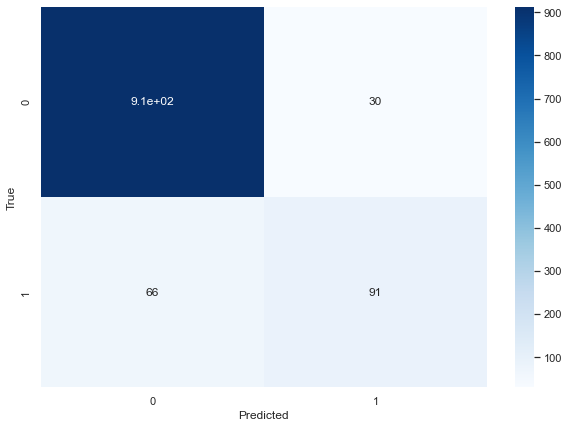

In [27]:
# Confusion Matrix for Classification Tree # 2

conf_mat(y_test, predictions_clf2)

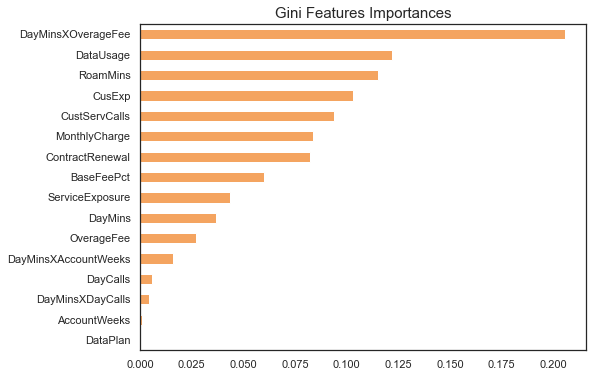

In [28]:
# Feature Importance for Classification Tree # 2

plot_feats(clf2)

## 2. RANDOM FOREST 

### Base Model 

In [29]:
# Fitting and Predicting Random Forest Base Model

rf = RandomForestClassifier(random_state=1)
rf, predictions_rf = fit_n_predict(X_train, X_test, y_train, rf)

Accuracy Score: 0.94
Precision Score: 0.88
Recall Score: 0.64
F1 Score: 0.74


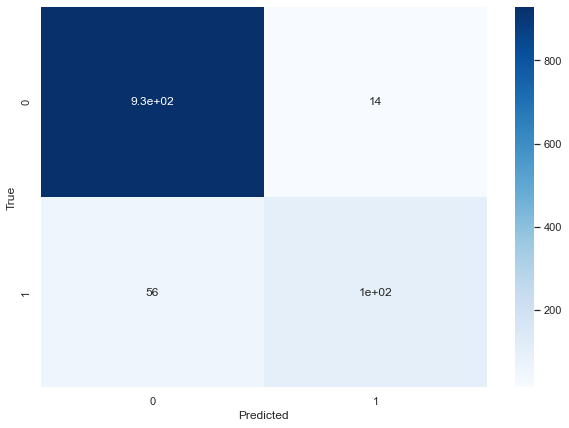

In [30]:
# Confusion Matrix for Random Forest Base Model

conf_mat(y_test, predictions_rf)


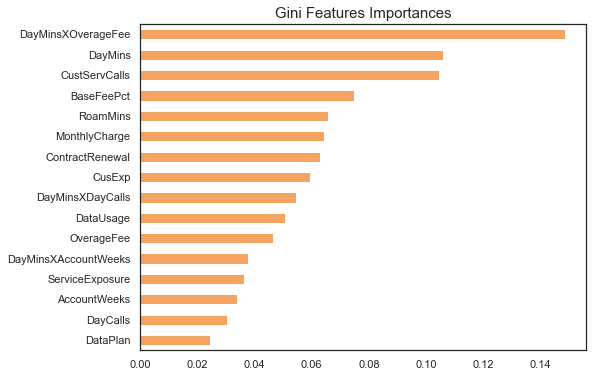

In [31]:
# Feature Importance for Random Forest Base Model

plot_feats(rf)

### Random Forest: Hyperparameter Tuning 

In [32]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Finding the best hyperparameters for the random forest model
parameters_forest = {
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [4, 5, 6, 7, 8, 9, 10, 11, 12],
    "max_features" : ['auto', 'log2', 'sqrt'],
    "min_samples_split" : [2, 4, 6, 8, 10]
}

rf2 = tuning(RandomForestClassifier(random_state=1), parameters_forest, X_train, y_train)

rf2

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Estimator:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=8, random_state=1)  



RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=8, random_state=1)

In [34]:
# Fitting and Predicting Tuned Model with the Best Features (Random Forest # 2)

rf2, predictions_rf2 = fit_n_predict(X_train, X_test, y_train, rf2)

Accuracy Score: 0.94
Precision Score: 0.90
Recall Score: 0.63
F1 Score: 0.74


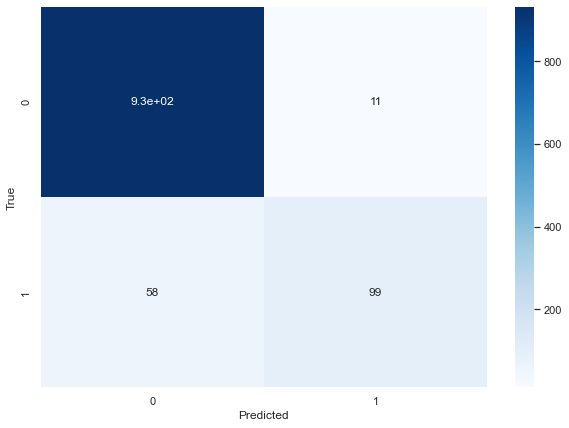

In [35]:
# Confusion Matrix for Random Forest # 2

conf_mat(y_test, predictions_rf2)

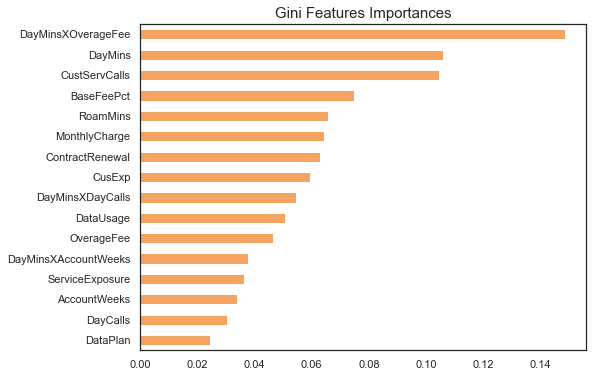

In [36]:
# Feature Importance for Random Forest # 2

plot_feats(rf)

## 3. ADA BOOST 

### Base Model 

In [37]:
# Estimate the ADABoost Base Model

ada = AdaBoostClassifier()
ada, predictions_ada = fit_n_predict(X_train, X_test, y_train, ada)

Accuracy Score: 0.90
Precision Score: 0.70
Recall Score: 0.48
F1 Score: 0.57


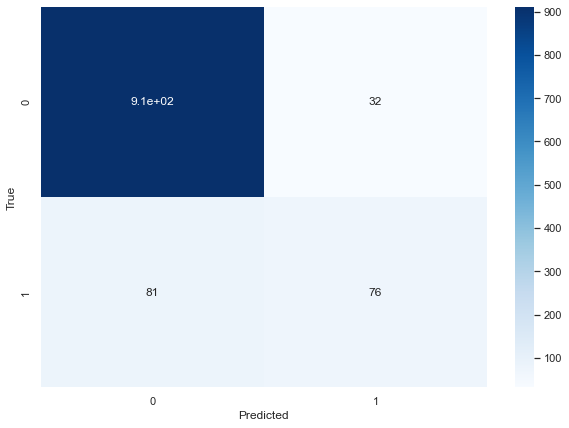

In [38]:
# Confusion Matrix for ADABoost Base Model

conf_mat(y_test, predictions_ada)

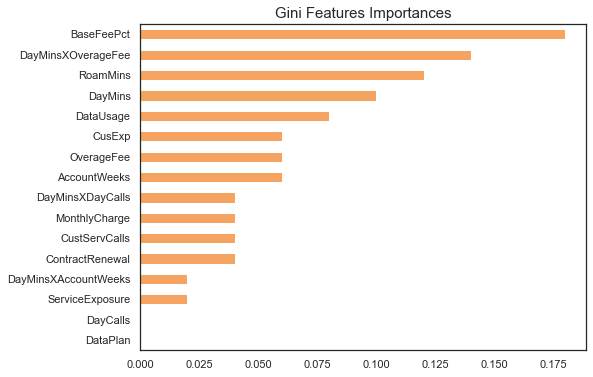

In [39]:
# Feature Importance for ADABoost Base Model

plot_feats(ada)

### ADA Boost: Hyperparameter Tuning 

In [40]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [41]:
# Finding the best hyperparameters for the ADABoost Model
parameters_ada = {
    "n_estimators" : [10,20,50,80,100,200, 300,500],
    "learning_rate": [0.8,0.9,1.0, 1.1, 1.2, 1.3, 1.4, 1.5]}

ada2 = tuning(AdaBoostClassifier(), parameters_ada, X_train, y_train)

ada2

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Estimator:  AdaBoostClassifier(learning_rate=1.5, n_estimators=10)  



AdaBoostClassifier(learning_rate=1.5, n_estimators=10)

In [42]:
# Fitting and Predicting Tuned Model with the Best Features (ADA Boost # 2)

ada2, predictions_ada2 = fit_n_predict(X_train, X_test, y_train, ada2)

Accuracy Score: 0.88
Precision Score: 0.61
Recall Score: 0.49
F1 Score: 0.54


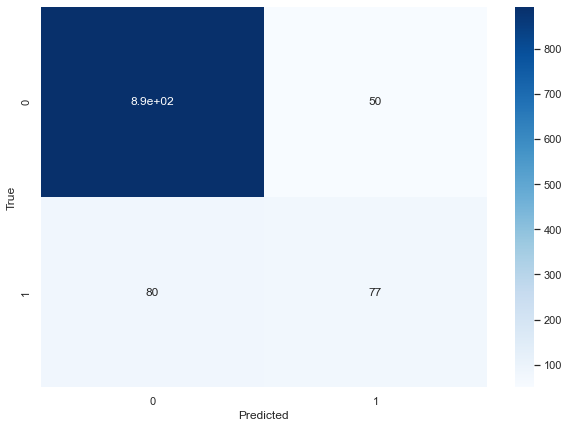

In [43]:
# Confusion Matrix for ADA Boost Model # 2

conf_mat(y_test, predictions_ada2)

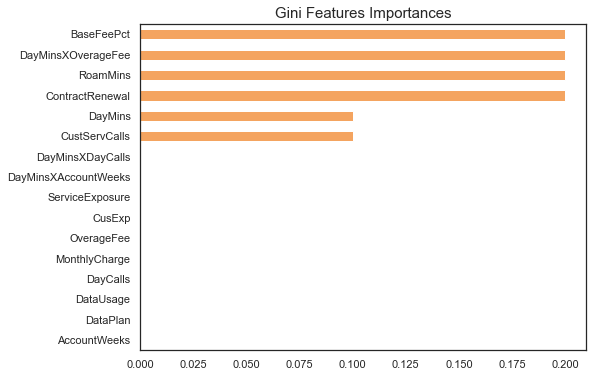

In [44]:
# Feature Importance for ADA Boost Model # 2

plot_feats(ada2)

## 4. XGBoost

### Base Model 

In [45]:
# Estimate the XGBoost Base Model

xgb = XGBClassifier(random_state=1)
xgb, predictions_xgb = fit_n_predict(X_train, X_test, y_train, xgb)

Accuracy Score: 0.93
Precision Score: 0.82
Recall Score: 0.66
F1 Score: 0.73


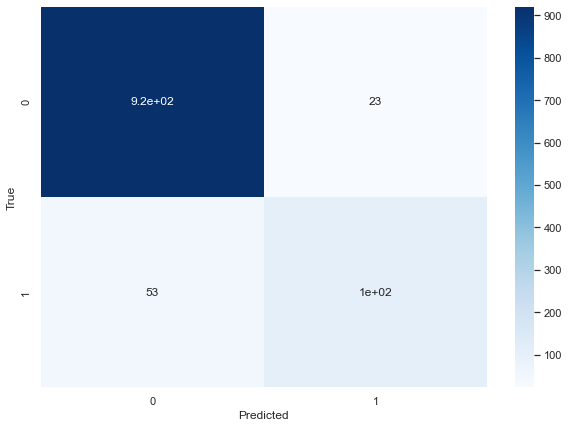

In [46]:
# Confusion Matrix for XGBoost Base Model

conf_mat(y_test, predictions_xgb)

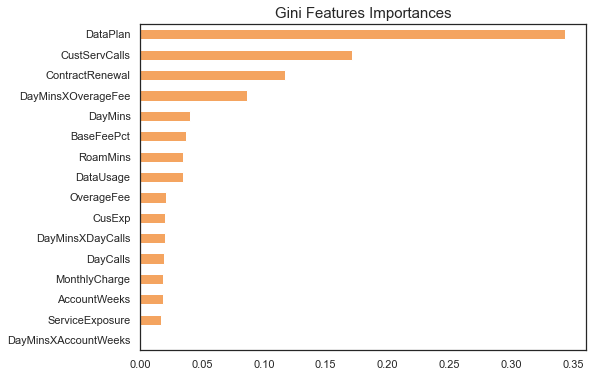

In [47]:
# Feature Importance for XGBoost Base Model

plot_feats(xgb)

### XGBoost: Hyperparameter Tuning 

In [48]:
# Finding the best hyperparameters for the XGBoost Model
parameters_xgb = {
 "max_depth"        : [4, 5, 6, 7, 8, 9, 10, 11, 12],  
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25] ,
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}

xgb2 = tuning(XGBClassifier(random_state=1), parameters_xgb, X_train, y_train)

xgb2

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)  



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [49]:
# Fitting and Predicting Tuned Model with the Best Features (XGBoost # 2)

xgb2, predictions_xgb2 = fit_n_predict(X_train, X_test, y_train, xgb2)

Accuracy Score: 0.94
Precision Score: 0.90
Recall Score: 0.66
F1 Score: 0.76


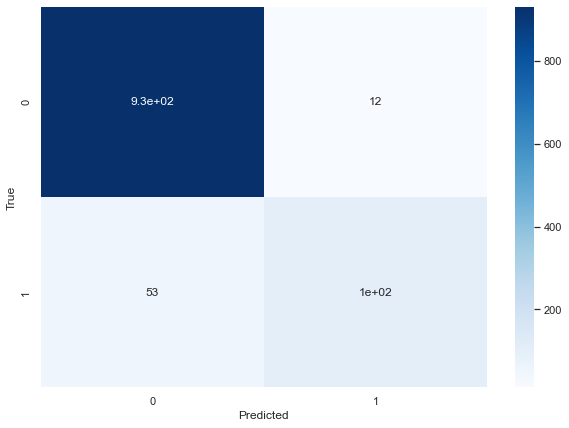

In [50]:
# Confusion Matrix for XGBoost # 2

conf_mat(y_test, predictions_xgb2)

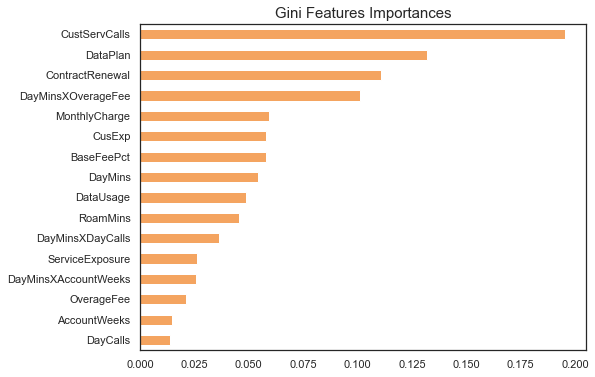

In [51]:
# Feature Importance for XGBoost Model # 2

plot_feats(xgb2)

# ROC Curve

In [52]:
from sklearn import metrics
from sklearn .metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [53]:
## Predict probabilities
pred_prob_clf2 = clf2.predict_proba(X_test)[:,1]
pred_prob_rf2 = rf2.predict_proba(X_test)[:,1]
pred_prob_ada2 = ada2.predict_proba(X_test)[:,1]
pred_prob_xgb2 = xgb2.predict_proba(X_test)[:,1]

# roc curve for models
fpr1, tpr1, thresh1 = metrics.roc_curve(y_test, pred_prob_clf2, pos_label=1)
fpr2, tpr2, thresh2 = metrics.roc_curve(y_test, pred_prob_rf2, pos_label=1)
fpr3, tpr3, thresh3 = metrics.roc_curve(y_test, pred_prob_ada2, pos_label=1)
fpr4, tpr4, thresh4 = metrics.roc_curve(y_test, pred_prob_xgb2, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_clf = roc_auc_score(y_test, pred_prob_clf2)
auc_rf = roc_auc_score(y_test, pred_prob_rf2)
auc_ada = roc_auc_score(y_test, pred_prob_ada2)
auc_xgb = roc_auc_score(y_test, pred_prob_xgb2)

print("Auc for Classification Tree is {}". format(auc_clf))
print("Auc for RF is {}". format(auc_rf))
print("Auc for Ada is {}". format(auc_ada))
print("Auc for Xgboost is {}". format(auc_xgb))

Auc for Classification Tree is 0.8294135129110916
Auc for RF is 0.9006828727938346
Auc for Ada is 0.8391905492026396
Auc for Xgboost is 0.8938271271386211


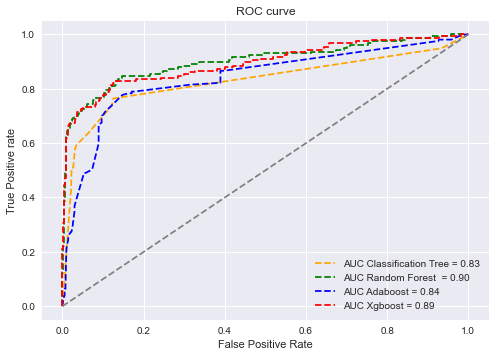

In [54]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='AUC Classification Tree = {:.2f}'.format(auc_clf))
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='AUC Random Forest  = {:.2f}'.format(auc_rf))
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='AUC Adaboost = {:.2f}'.format(auc_ada))
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='AUC Xgboost = {:.2f}'.format(auc_xgb))
plt.plot(p_fpr, p_tpr, linestyle='--', color='grey')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')

The ROC Curve demonstrates that the Random Forest with Hyperparameterized Tuning is the most optimal estimator for our target variable Churn as it has the highest AUC score out of all models that were tested.

## Questions to Answer

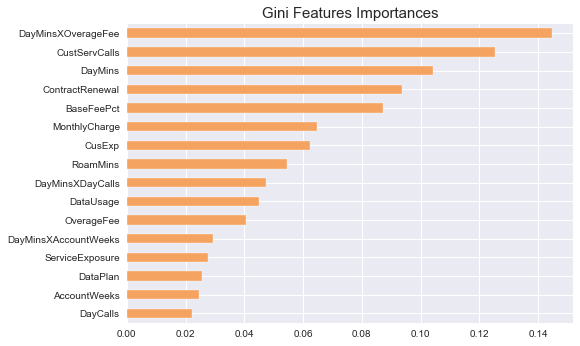

In [55]:
plot_feats(rf2)

1. <b>What variables are contributing to customer churn?</b>

Using the Features Importance graph of our best model, Random Forest, we see that the following 5 variables contribute to customer churn the most:

- DayMinsxOverageFee
- DayMins
- CustServCalls
- BaseFeePct
- RoamMins
    
2. <b>Who are the customers more likely to churn?</b> 
    
Seeing that the variable DayMinsxOverageFee has the highest influence on customer churn, we can assume that customers who tend to consume more daytime minutes on average get charged more overage fees, which, in turn, results in them leaving the telecommunications provider.

Another important variable that drives customer churn is CustServCalls. Normally, customers who are dissatisfied with the services provided are more likely to contact customer support, and thus have a higher chance of switching providers if their needs are not met.

3. <b>What actions can be taken to stop them from leaving?</b>
    
- DayMinsxOverageFee: <br>
Targeting customers who have a history of being charged for going over their allotted daytime minutes and offering special packages or deals will aid in retaining these customers and thus reduce customer churn.<br>

- CustServCalls: <br>
As shown in the graph in the Exploratory Data Analysis section, customer churn tends to noticeably increase after the fourth call. Thus, the telecommunications provider must pay close attention once a customer is nearing this threshold. Offering special discounts or deals might help retain these customers.

However we must note that the benefits of retaining these types of customers must outweigh the cost of offering these special promotions. If the appropriate data is available, a cost-benefit analysis should be implemented.